# Dams valley management

Consider two dams in the same valley. These two dams are connected together, as we suppose that the water turbined by the first dam is an input of the second dam. The goal of this notebook is to show how to use the Stochastic Dual Dynamic Programming (SDDP) algorithm to find how to manage optimally these two dams. 

## Mathematical formulation:

Assume that we have a water inflow $W_t$ which arrives in the first dam between $t$ and $t+1$. This dam turbines a quantity $U_t^1$ of water, and spill a quantity $S_t^1$. 

Its dynamic is: 

$$ X_{t+1}^1 = X_{t}^1 + W^t - U_t^1 - S_t^1 $$

The turbined flow arrives in the second dam, which turbines a quantity $U_t^2$ and spills a quantity $S_t^2$. So its dynamic is:

$$ X_{t+1}^2 = X_{t}^2 + U_t^1 + S_t^1 - U_t^2 - S_t^2 $$

Thus, we could define the state:
$$ X_t = (X_t^1, X_t^2)$$

and the control:
$$U_t = (U_t^1, U_t^2, S_t^1, S_t^2) $$

The two turbines produce a quantity of electricity proportionnal to the flow turbined, and this electricity is sold into the market at a price $c_t$. So we gain at each timestep:

$$ C_t(X_t, U_t) = c_t  (U_t^1 + U_t^2) $$

Here, we suppose that costs are negative, as we sell electricity onto the network. 

We want to maximize our expected gains, so we minimize the following quantity:

$$ J = \mathbb{E} \left[ \sum_{i=1}^{T_f} C_t(X_t, U_t) \right]$$ 

## Problem formulation: 

First, we need to import some modules: 

In [1]:
using JuMP, Clp, StochDynamicProgramming, PyPlot

JuMP is the julia module for Mathematical Programming, 
  Clp the module calling a linear solver (can be replaced by CPLEX or Gurobi), 
 StochDynamicProgramming is a SDDP module in Julia, 
 PyPlot is used here to plot the results 
 

---
### Constants definition

Then, we define the constants of this problem: 

In [2]:
# Number of timesteps (as we manage the dams over a year, it is equal to the number of weeks):
TF = 52

# Capacity of dams: 
VOLUME_MAX = 100
VOLUME_MIN = 0

# Specify the maximum flow that could be turnined: 
CONTROL_MAX = round(Int, .4/7. * VOLUME_MAX) + 1
CONTROL_MIN = 0

# Some statistics about aleas (water inflow):
W_MAX = round(Int, .5/7. * VOLUME_MAX)
W_MIN = 0
DW = 1

T0 = 1

# Define aleas' space:
N_ALEAS = Int(round(Int, (W_MAX - W_MIN) / DW + 1))
ALEAS = linspace(W_MIN, W_MAX, N_ALEAS);


Now, we generate a random process to simulate the evolution of electricity prices over a year: 

In [3]:
COST = -66*2.7*(1 + .5*(rand(TF) - .5));

We could plot the evolution of prices with matplotlib: 

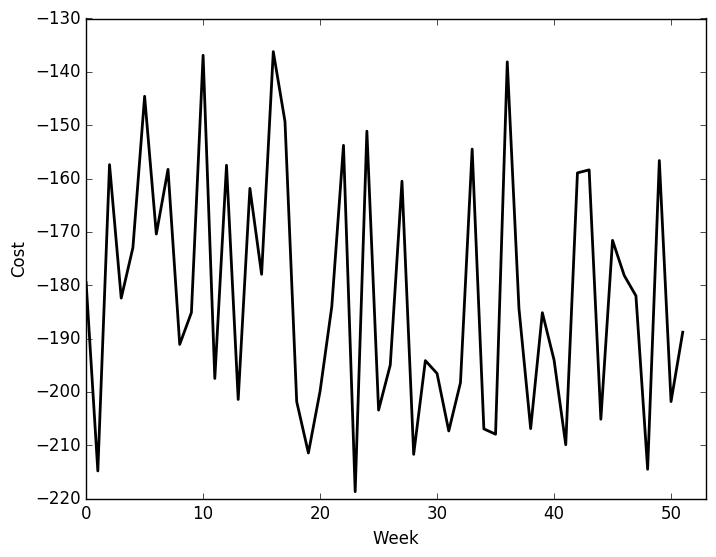

PyObject <matplotlib.text.Text object at 0x7f34341b8b90>

In [4]:
plot(COST, color="k", lw=2)
xlim(0, 53)
xlabel("Week")
ylabel("Cost")

---
### Dynamic, costs and aleas


---

We could now define the dynamic of our system: 

In [27]:
# Define dynamic of the dam:
function dynamic(t, x, u, w)
    return [x[1] - u[1] - u[3] + w[1], x[2] - u[2] - u[4] + u[1] + u[3]]
end


dynamic (generic function with 1 method)

and the cost at time $t$:

In [6]:
# Define cost corresponding to each timestep:
function cost_t(t, x, u, w)
    return COST[t] * (u[1] + u[2])
end

cost_t (generic function with 1 method)

Now, we build a function to simulate the evolution of water inflow over one year. We aim to have less water in summer than in winter. 




In [7]:
"""Build aleas probabilities for each month."""
function build_aleas()
    aleas = zeros(N_ALEAS, TF)

    # take into account seasonality effects:
    unorm_prob = linspace(1, N_ALEAS, N_ALEAS)
    proba1 = unorm_prob / sum(unorm_prob)
    proba2 = proba1[N_ALEAS:-1:1]

    for t in 1:TF
        aleas[:, t] = (1 - sin(pi*t/TF)) * proba1 + sin(pi*t/TF) * proba2
    end
    return aleas
end


"""Build an admissible scenario for water inflow."""
function build_scenarios(n_scenarios::Int64, probabilities)
    scenarios = zeros(n_scenarios, TF)

    for scen in 1:n_scenarios
        for t in 1:TF
            Pcum = cumsum(probabilities[:, t])

            n_random = rand()
            prob = findfirst(x -> x > n_random, Pcum)
            scenarios[scen, t] = prob
        end
    end
    return scenarios
end

build_scenarios

We could test our generator with one scenario: 

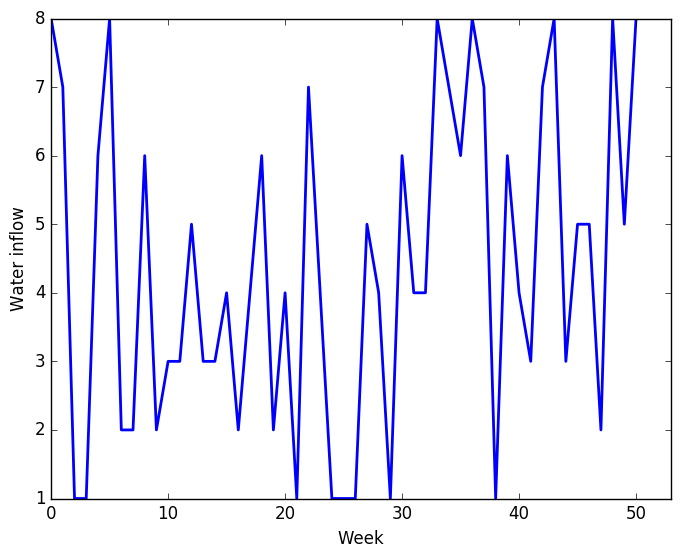

(0,53)

In [8]:
scenario = build_scenarios(1, build_aleas());

plot(scenario', lw=2, color="blue")
xlabel("Week")
ylabel("Water inflow")
xlim(0, 53)

---
To use these scenarios in SDDP, we must use a discrete distribution for each timestep. The following function generates `n_scenarios` and returns a vector of `NoiseLaw` corresponding to the evolution of aleas distribution along the time: 

In [9]:
"""Build probability distribution at each timestep.

Return a Vector{NoiseLaw}"""
function generate_probability_laws(n_scenarios)
    aleas = build_scenarios(n_scenarios, build_aleas())

    laws = Vector{NoiseLaw}(TF-1)

    # uniform probabilities:
    proba = 1/n_scenarios*ones(n_scenarios)

    for t=1:TF-1
        laws[t] = NoiseLaw(aleas[:, t], proba)
    end

    return laws
end

generate_probability_laws

---

## Solving the problem with SDDP

### SDDP model

We generate 10 scenarios and fit a probability distribution at each timestep: 

In [10]:
N_SCENARIO = 10
aleas = generate_probability_laws(10);

---
We define the bounds over the state and the control:

In [11]:
x_bounds = [(VOLUME_MIN, VOLUME_MAX), (VOLUME_MIN, VOLUME_MAX)];
u_bounds = [(CONTROL_MIN, CONTROL_MAX), (CONTROL_MIN, CONTROL_MAX), (0, Inf), (0, Inf)];

and the initial position $X_0$:

In [12]:
x0 = [50, 50]

2-element Array{Int64,1}:
 50
 50

We build an instance of `LinearDynamicLinearCostSPModel` to translate our problem in SDDP: 

In [13]:
model = LinearSPModel(TF, # number of timestep
                    u_bounds, # control bounds
                    x0, # initial state
                    cost_t, # cost function
                    dynamic, # dynamic function 
                    aleas);


We add bounds to state:

In [14]:
set_state_bounds(model, x_bounds)

2-element Array{Tuple{Int64,Int64},1}:
 (0,100)
 (0,100)

---
### SDDP parameters

We define the parameters of the algorithm: 

In [30]:
# LP solver: 
solver = ClpSolver()
# Set tolerance at 0.1% for convergence: 
EPSILON = 0.001
# Maximum iterations: 
MAX_ITER = 50


params = SDDPparameters(solver,
                        passnumber=10,
                        gap=EPSILON,
                        compute_ub=5, 
                        montecarlo_in_iter=1000, 
                        max_iterations=MAX_ITER);

---
### SDDP solving

We could launch the SDDP algorithm to our problem: 

In [31]:
V, pbs, stats = @time solve_SDDP(model, params, 1);

Initial value function loaded into memory.
Initialize cuts
Pass number 1	Lower-bound: -119711.2162	Time: 1.03s
Pass number 2	Lower-bound: -115145.9875	Time: 1.16s
Pass number 3	Lower-bound: -113161.6009	Time: 1.23s
Pass number 4	Lower-bound: -112718.2165	Time: 1.4s
Pass number 5	Lower-bound: -110441.2794	Time: 1.5s
Compute upper-bound with 1000 scenarios...
Pass number 6	Upper-bound: -107992.77701400021	Lower-bound: -110052.663	Time: 1.59s
Pass number 7	Upper-bound: -107992.77701400021	Lower-bound: -109865.5478	Time: 1.74s
Pass number 8	Upper-bound: -107992.77701400021	Lower-bound: -109571.5242	Time: 1.83s
Pass number 9	Upper-bound: -107992.77701400021	Lower-bound: -109551.5736	Time: 1.94s
Pass number 10	Upper-bound: -107992.77701400021	Lower-bound: -109288.3783	Time: 2.04s
Compute upper-bound with 1000 scenarios...
Pass number 11	Upper-bound: -109079.88107520078	Lower-bound: -109279.94	Time: 2.17s
Pass number 12	Upper-bound: -109079.88107520078	Lower-bound: -109277.7181	Time: 2.29s
Pa

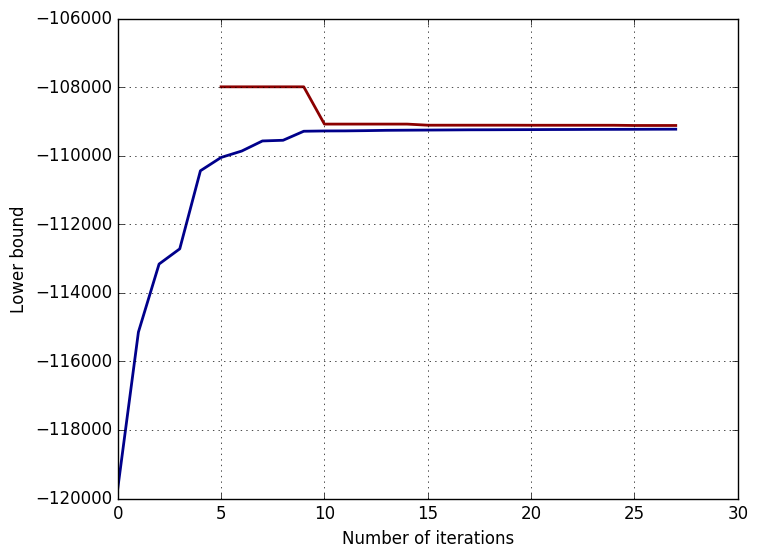

In [36]:
# We plot evolution of lower-bound: 

plot(stats.upper_bounds, lw=2, c="darkred", lw=2)

plot(stats.lower_bounds, lw=2, c="darkblue", lw=2)
grid()
xlabel("Number of iterations")
ylabel("Lower bound");

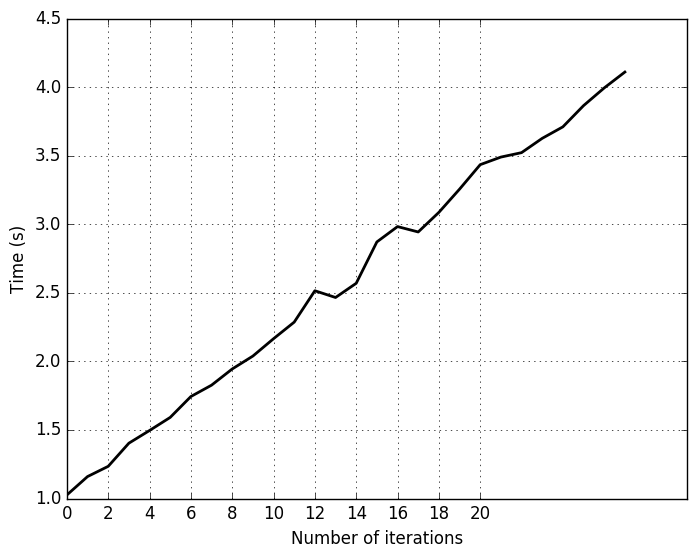

In [37]:
# and evolution of execution time: 
plot(stats.exectime, lw=2, c="k")
grid()
xticks(0:2:20, 0:2:20)
xlabel("Number of iterations")
ylabel("Time (s)");

The algorithm returns the bellman functions (`V`) and a vector of `JuMP.Model` used to approximate these functions with linear cuts. 



---
## Test SDDP with an example 

### Input scenario

We suppose given a scenario of inflows: 


In [38]:
alea_year = Array([7.0 7.0 8.0 3.0 1.0 1.0 3.0 4.0 3.0 2.0 6.0 5.0 2.0 6.0 4.0 7.0 3.0 4.0 1.0 1.0 6.0 2.0 2.0 8.0 3.0 7.0 3.0 1.0 4.0 2.0 4.0 1.0 3.0 2.0 8.0 1.0 5.0 5.0 2.0 1.0 6.0 7.0 5.0 1.0 7.0 7.0 7.0 4.0 3.0 2.0 8.0 7.0])


1×52 Array{Float64,2}:
 7.0  7.0  8.0  3.0  1.0  1.0  3.0  4.0  …  7.0  7.0  4.0  3.0  2.0  8.0  7.0

We store this scenario as a 3D array, so it could be used to compute a forward-pass:

In [39]:
aleas = zeros(52, 1, 1)
aleas[:, 1, 1] = alea_year;


---
### SDDP simulation

We have only one scenario, so we set the forwardPassNumber equal to 1: 

Find the optimal control with a forward simulation: 

In [40]:
costs, stocks = forward_simulations(model, params, pbs, aleas);

---
### Results 

The cost is: 

In [41]:
SDDP_COST = costs[1]
println("SDDP cost: ", SDDP_COST)

SDDP cost: -106450.51674382594


And the optimal solution is: 

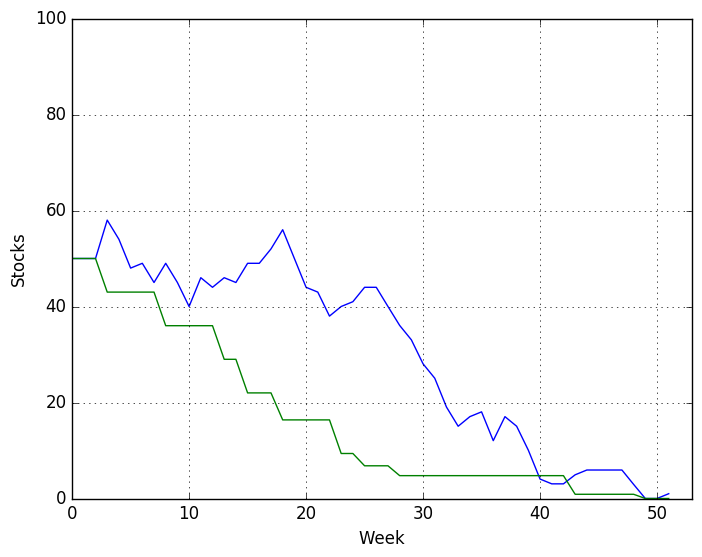

In [42]:
plot(stocks[:, :, 1])
plot(stocks[:, :, 2])
xlabel("Week")
ylabel("Stocks")
grid()
ylim(0, 100)
xlim(0, 53);


---
## Comparison with the deterministic solution 
To check the results given by SDDP, we solve the deterministic problem with JuMP: 

In [43]:
m = Model(solver=solver)


@variable(m,  VOLUME_MIN  <= x1[1:(TF+1)]  <= VOLUME_MAX)
@variable(m,  VOLUME_MIN  <= x2[1:(TF+1)]  <= VOLUME_MAX)
@variable(m,  CONTROL_MIN <= u1[1:TF]  <= CONTROL_MAX)
@variable(m,  CONTROL_MIN <= u2[1:TF]  <= CONTROL_MAX)
@variable(m, u3[1:TF] >= 0)
@variable(m, u4[1:TF] >= 0)

@objective(m, Min, sum{COST[i]*(u1[i] + u2[i]), i = 1:TF})

for i in 1:TF
    @constraint(m, x1[i+1] - x1[i] + u1[i] + u3[i] - alea_year[i] == 0)
    @constraint(m, x2[i+1] - x2[i] + u2[i] + u4[i] - u1[i] - u3[i] == 0)
end

@constraint(m, x1[1] == x0[1])
@constraint(m, x2[1] == x0[2])

status = solve(m)
println(status)

LP_COST = getobjectivevalue(m)
println("LP value: ", LP_COST)

Optimal
LP value: -109257.50353623425


And we plot the evolution of the stocks:

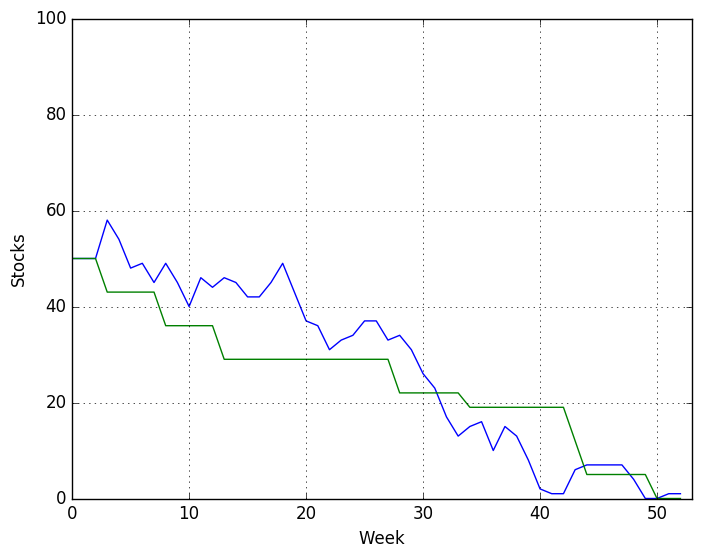

In [44]:
plot(getvalue(x1))
plot(getvalue(x2))
xlabel("Week")
ylabel("Stocks")
grid()
ylim(0, 100)
xlim(0, 53);

The solution given by the solver is more optimistic, as it assumes that the future is known in advance. 

If we consider the costs, we have a discrepancy between the two solutions :


In [45]:
abs((LP_COST - SDDP_COST)/LP_COST)


0.02569147840246411